(10, 1, 6, 997)
(10, 1, 6, 997)


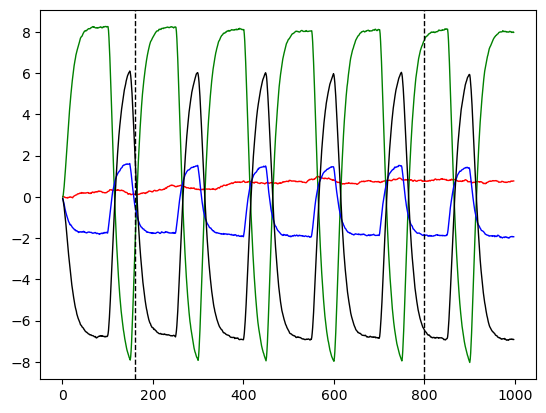

In [1]:

from toolbox import OneDModel_TBK as ODM
import importlib
importlib.reload(ODM)

# Temps_ori, F, Fadv = ODM.OneDModel(wnoise_level = 0.01, if_shift=True, lag_multiplier=2, show_figures=False)
Temps_ori, F, Fadv = ODM.OneDModel(wnoise_level = 0.01, runlength=1000, bpss_reoccurence=100, bpss_length=50, if_shift=True, lag_multiplier=1, show_figures=False)

import matplotlib.pyplot as plt
import numpy as np


# Resample by taking every 10th value along the time dimension
# Temps = Temps_ori[:, :, :, ::10]

Temps=Temps_ori

time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) + 1)

plt.figure()
idx=3
# Last loop (i == 10), plot in black
plt.plot(time, Temps[idx, 0, 1, :], 'r', linewidth=1)
plt.plot(time, Temps[idx, 0, 2, :], 'g', linewidth=1)
plt.plot(time, Temps[idx, 0, 3, :], 'b', linewidth=1)
plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)

# plot vertical lies at time =190 and 210
# plt.axvline(x=160, color='k', linestyle='--', linewidth=1)
# plt.axvline(x=240, color='k', linestyle='--', linewidth=1)

plt.axvline(x=160, color='k', linestyle='--', linewidth=1)
plt.axvline(x=800, color='k', linestyle='--', linewidth=1)

# print the shape of original data and resampled data
print(Temps_ori.shape)
print(Temps.shape)

(997, 4)


Text(0, 0.5, 'Temperature')

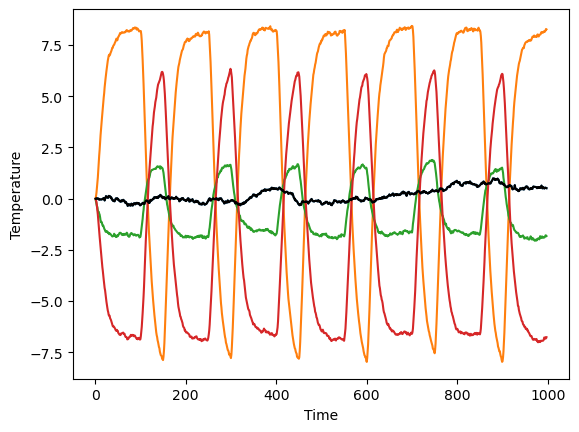

In [2]:
idx = 4  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()
time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) + 1)
# print the shape of data_array
print(data_array.shape)

# # For data_array, for the first column, replace it with its derivative
# first_col_diff = np.diff(data_array[:, 0])
# # drop the last row of data_array
# data_array = data_array[:-1, :]
# data_array[:, 0] = first_col_diff

# time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) )

# plot the data_array time series
import matplotlib.pyplot as plt
plt.plot(time, data_array)
plt.plot(time, data_array[:, 0], 'k', label='BOX 1')
plt.xlabel('Time')
plt.ylabel('Temperature')

In [5]:


import pyEDM
import matplotlib.pyplot as plt

def find_best_E(df, E_values, data_column='d18O', 
                lib=None, pred=None, tau=-1, Tp=1, noTime=False):
    """
    df          : DataFrame with columns [Time, data_column]
    E_values    : iterable of embedding dimensions to test
    data_column : name of the column to forecast
    lib         : string specifying the library rows, e.g. '1 900'
    pred        : string specifying the prediction rows, e.g. '901 1851'
    tau         : embedding time-lag (default -1 = let pyEDM guess or use default)
    Tp          : prediction horizon (default 1)
    noTime      : if True, pyEDM will assume there's no separate time column
    """
    N = len(df)
    if lib is None or pred is None:
        # Example: first half for library, second half for prediction
        mid = N // 2
        lib  = f"1 {mid}"
        pred = f"{mid+1} {N}"
    
    results = {}
    for E in E_values:
        # Run Simplex
        simplex_out = pyEDM.Simplex(
            dataFrame = df,
            columns   = data_column,  # library columns
            target    = data_column,  # predict the same variable
            lib       = lib,
            pred      = pred,
            E         = E,
            Tp        = Tp,
            tau       = tau,
            knn       = 0,        # 0 => use E+1 neighbors
            embedded  = False,    # let pyEDM embed for us
            noTime    = noTime,   # if the first column is Time, set noTime=False
            showPlot  = False
        )
        
        # simplex_out is a DataFrame with columns ["Time","Observations","Predictions"]
        obs = simplex_out["Observations"].values
        pred_ = simplex_out["Predictions"].values
        
        # Compute correlation, ignoring NaNs
        valid_idx = ~np.isnan(obs) & ~np.isnan(pred_)
        if np.sum(valid_idx) > 1:
            rho_val = np.corrcoef(obs[valid_idx], pred_[valid_idx])[0,1]
        else:
            rho_val = np.nan
        
        results[E] = rho_val
    
    return results


In [6]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Prepare DataFrame
df = pd.DataFrame({
    'time': time,
    'X': data_array[:, 1],  
    'Y': data_array[:, 2],    
})


tau_values   = range(1, 10, 1)  # 10,20,30,...,100
E_candidates = range(1, 5)        # 1..8

# 2) We'll store results in 2D arrays:
#    rows = different tau, cols = different E
ant_results_3d   = np.zeros((len(tau_values), len(E_candidates)))
ngrip_results_3d = np.zeros((len(tau_values), len(E_candidates)))

# 3) Loop over all tau and E values to fill in the 2D arrays
for i, tau in enumerate(tau_values):
    ant_results = find_best_E(
        df, 
        E_values = E_candidates, 
        data_column = 'X',
        tau = tau,
        Tp = tau,           # forecast tau steps ahead
        lib='1 400',        # e.g. rows 1..900 as library
        pred='401 801',    # rows 901..1851 as prediction
        noTime=False
    )
    ngrip_results = find_best_E(
        df, 
        E_values = E_candidates, 
        data_column = 'Y',
        tau = tau,
        Tp = tau,
        lib='1 400',
        pred='401 801',
        noTime=False
    )
    
    for j, E in enumerate(E_candidates):
        ant_results_3d[i,j]   = ant_results[E]
        ngrip_results_3d[i,j] = ngrip_results[E]

# e.g. to create mesh for x=E, y=tau:
E_grid, Tau_grid = np.meshgrid(E_candidates, tau_values)  # each shape: (len(tau_values), len(E_candidates))


# Create a 1x2 grid of 3D subplots
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=["BOX2", "BOX3"]
)

# -- Add the Antarctic surface (left subplot, row=1,col=1)
fig.add_trace(
    go.Surface(
        x=E_grid,          # embedding dimension
        y=Tau_grid,        # tau
        z=ant_results_3d,  # correlation skill
        colorscale='Viridis',
        name='BOX2'
    ),
    row=1, col=1
)

# -- Add the NGRIP surface (right subplot, row=1,col=2)
fig.add_trace(
    go.Surface(
        x=E_grid,
        y=Tau_grid,
        z=ngrip_results_3d,
        colorscale='Viridis',
        name='BOX3'
    ),
    row=1, col=2
)

# Update layout for each subplot’s axes and overall figure
fig.update_layout(
    title="Forecast Skill vs. E and tau (Tp = tau)",
    width=1200, height=600
)

# Customize the axis titles on each 3D subplot
fig.update_scenes(
    dict(
        xaxis_title="E (Embedding Dimension)",
        yaxis_title="tau (Lag & Forecast Steps)",
        zaxis_title="Forecast Skill (rho)"
    ),  # scene1 settings
    row=1, col=1
)
fig.update_scenes(
    dict(
        xaxis_title="E (Embedding Dimension)",
        yaxis_title="tau (Lag & Forecast Steps)",
        zaxis_title="Forecast Skill (rho)"
    ),  # scene2 settings
    row=1, col=2
)

fig.show()


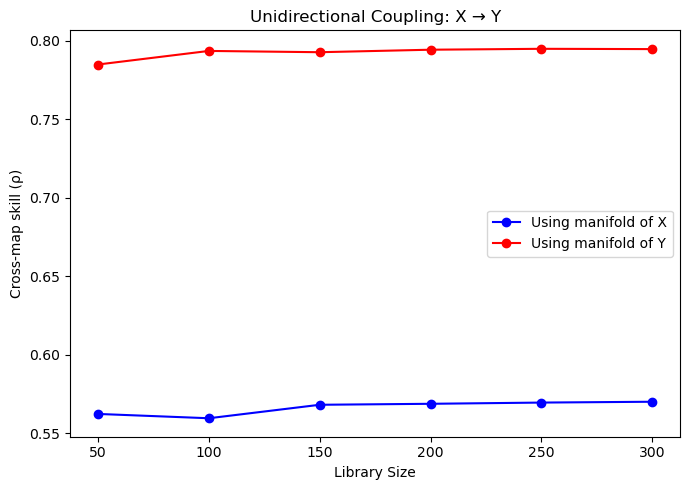

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM

# ---------------------
# 1) Generate synthetic data
# ---------------------
N = 1000
np.random.seed(42)

X = np.zeros(N)
Y = np.zeros(N)

# Parameters for the unidirectional coupling: X -> Y
aX = 0.8   # How strongly X depends on its own past
aY = 0.4   # How strongly Y depends on its own past
cXY = 0.9  # Coupling strength: Y depends on X
noise_std = 0.3

# Initialize
X[0] = 0.0
Y[0] = 0.0

# Evolve the system
for t in range(1, N):
    # X is an AR(1) process
    X[t] = aX * X[t - 1] + noise_std * np.random.randn()
    # Y depends on Y[t-1] and also X[t-1]
    Y[t] = aY * Y[t - 1] + cXY * X[t - 1] + noise_std * np.random.randn()

# Create a time column for consistency
time = np.arange(N)

# Put into a DataFrame
df = pd.DataFrame({
    'time': time,
    'X': X,
    'Y': Y
})

# ---------------------
# 2) Run CCM for X->Y and Y->X
# ---------------------
# We'll try a small range of library sizes 
libSizes = "50 100 150 200 250 300"

# A) X->Y
ccm_out = CCM(
    dataFrame   = df,
    E           = 2,       # Embedding dimension
    tau         = 1,
    columns     = "X",     # 'X' is the manifold (cause)
    target      = "Y",     # 'Y' is the effect
    libSizes    = libSizes,
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 0,       # Forecast horizon
    verbose     = False
)


plt.figure(figsize=(7,5))
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='Using manifold of X')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='Using manifold of Y')

plt.xlabel('Library Size')
plt.ylabel('Cross-map skill (ρ)')
plt.title('Unidirectional Coupling: X → Y')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
from pyEDM import CCM

# For 3D plotting
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prepare DataFrame
df = pd.DataFrame({
    'time': time,
    'X': data_array[:, 1],  
    'Y': data_array[:, 2],    
})

# Define parameter sweeps:
tau_list = [1, 2, 4, 6, 8, 10]
Tp_list  = range(-5, 6)  # -5 to +5 inclusive
E        = 3

# Create arrays to store the cross-map skill (at largest library size)
XtoY_matrix = np.zeros((len(tau_list), len(Tp_list)))
YtoX_matrix = np.zeros((len(tau_list), len(Tp_list)))

# Loop over tau and Tp
for i, tau in enumerate(tau_list):
    for j, Tp in enumerate(Tp_list):
        # Run CCM for columns='X' (predictor), target='Y'
        # This returns columns: LibSize, "X:Y", "Y:X"
        ccm_out = CCM(
            dataFrame   = df,
            E           = E,
            tau         = tau,
            columns     = "X",   # X is predictor (manifold)
            target      = "Y",   # Y is the target
            libSizes    = "100 200 300 400 500 600 700",
            sample      = 100,
            random      = True,
            replacement = False,
            Tp          = Tp,
            verbose     = False
        )
        
        # The DataFrame ccm_out has multiple rows, one per LibSize;
        # we take the LAST row for the largest library size:
        last_row = ccm_out.iloc[-1]
        
        # X:Y skill (predicting Y from X's manifold) at largest lib size:
        XtoY_matrix[i, j] = last_row["X:Y"]
        
        # Y:X skill (predicting X from Y's manifold) at largest lib size:
        YtoX_matrix[i, j] = last_row["Y:X"]

# Now we create two 3D surfaces in side-by-side subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "surface"}, {"type": "surface"}]],
    subplot_titles=["Using manifold of X", "Using manifold of Y"]
)



# 1) Add surface for X->Y
fig.add_trace(
    go.Surface(
        x = np.array(Tp_list),
        y = np.array(tau_list),
        z = XtoY_matrix,
        colorbar=dict(title="rho"),  # correlation scale
    ),
    row=1, col=1
)

# 2) Add surface for Y->X
fig.add_trace(
    go.Surface(
        x = np.array(Tp_list),
        y = np.array(tau_list),
        z = YtoX_matrix,
        colorbar=dict(title="rho"),  # correlation scale
    ),
    row=1, col=2
)

# Update the axis labels, layout, etc.
fig.update_layout(
    scene=dict(
        xaxis_title="T<sub>p</sub>",
        yaxis_title="tau",
        zaxis_title="Cross-map skill"
    ),
    scene2=dict(
        xaxis_title="T<sub>p</sub>",
        yaxis_title="tau",
        zaxis_title="Cross-map skill"
    ),
    title="CCM Skill for Sweeps of τ and T<sub>p</sub>",
    width=1000,
    height=600
)

fig.show()


   LibSize       X:Y       Y:X
0    100.0  0.330752  0.055990
1    200.0  0.392988  0.051689
2    300.0  0.426712  0.039711
3    400.0  0.450415  0.033349
4    500.0  0.467420  0.026669
5    600.0  0.481066  0.014385
6    700.0  0.490693  0.008356
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


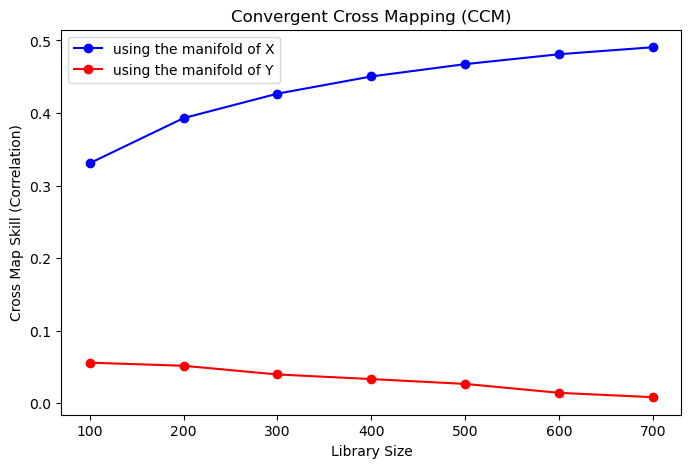

In [8]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt

# Prepare DataFrame
df = pd.DataFrame({
    'time': time,
    'X': data_array[:, 0],  
    'Y': data_array[:, 1],    
})

# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 5,
    columns     = "X",   # predictor (ngrip)
    target      = "Y",   # target (pre)
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 0,
    verbose     = True
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# Plot the results with custom legend labels
plt.figure(figsize=(8,5))
# For X:Y: predictor is ngrip, target is ant -> label: "ant^|Mngrip"
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='using the manifold of X')
# For Y:X: predictor is ant, target is ngrip -> label: "ngrip^|Mant"
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='using the manifold of Y')

plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (Correlation)')
plt.title('Convergent Cross Mapping (CCM)')
plt.legend(loc='best')
plt.show()


   LibSize       X:Y       Y:X
0    100.0  0.992040  0.984704
1    200.0  0.993063  0.988425
2    300.0  0.993596  0.989479
3    400.0  0.993848  0.990181
4    500.0  0.994032  0.990605
5    600.0  0.994304  0.990888
6    700.0  0.994518  0.991044
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


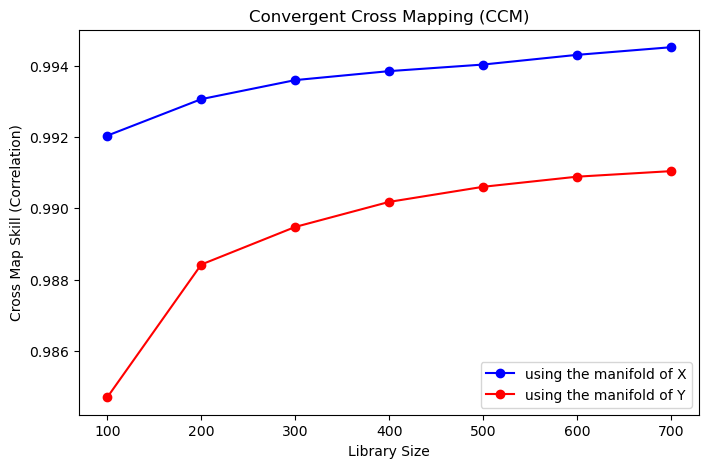

In [7]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt

# Prepare DataFrame
df = pd.DataFrame({
    'time': time,
    'X': data_array[:, 1],  
    'Y': data_array[:, 2],    
})

# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 5,
    columns     = "X",   # predictor (ngrip)
    target      = "Y",   # target (pre)
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 0,
    verbose     = True
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# Plot the results with custom legend labels
plt.figure(figsize=(8,5))
# For X:Y: predictor is ngrip, target is ant -> label: "ant^|Mngrip"
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='using the manifold of X')
# For Y:X: predictor is ant, target is ngrip -> label: "ngrip^|Mant"
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='using the manifold of Y')

plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (Correlation)')
plt.title('Convergent Cross Mapping (CCM)')
plt.legend(loc='best')
plt.show()

# See how rho changes with Tp

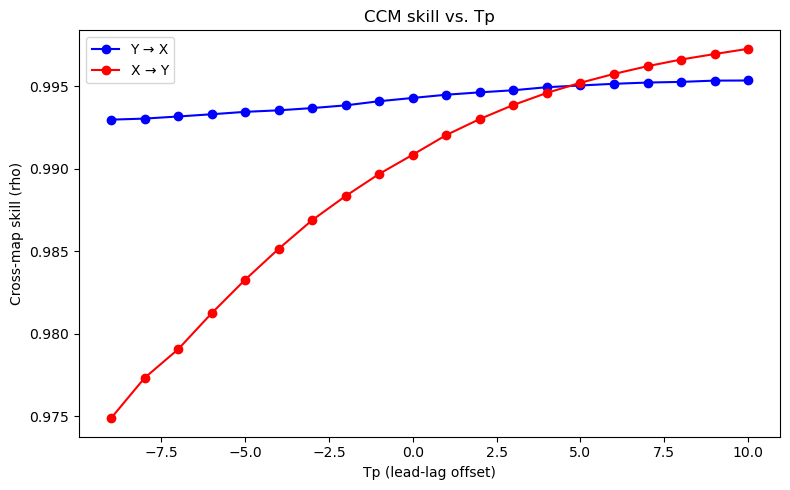

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM


N= len(time)

df = pd.DataFrame({
    'time': time,
    'X': data_array[:, 1],  
    'Y': data_array[:, 2],    
})

# ------------------------------------------------
# 2) Loop over Tp in steps of 2 from 0 to 30
# ------------------------------------------------
Tps = range(10, -10, -1)  # 0, 2, 4, ..., 30

XtoY_skills = []
YtoX_skills = []

for tp in Tps:
    # Run CCM once; PyEDM.CCM will report both X->Y and Y->X skill
    ccm_out = CCM(
        dataFrame   = df,
        E           = 3,                       # embedding dimension
        tau         = 5,                      # time delay (example)
        columns     = "X",                     # 'X' is the manifold source
        target      = "Y",                     # 'Y' is the variable we predict
        libSizes    = "200 400 600",  # library sizes
        sample      = 200,
        random      = True,
        replacement = False,
        Tp          = tp                       # vary this offset
    )

    # Extract final row (largest library size) for cross-map skill
    # ccm_out typically has columns: ['LibSize','X:Y','Y:X',...]
    final_row = ccm_out.iloc[-1]
    x_to_y_skill = final_row['X:Y']   # correlation for X->Y
    y_to_x_skill = final_row['Y:X']   # correlation for Y->X

    XtoY_skills.append(x_to_y_skill)
    YtoX_skills.append(y_to_x_skill)

# ------------------------------------------------
# 3) Plot the results
# ------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(Tps, XtoY_skills, 'bo-', label='Y → X')
plt.plot(Tps, YtoX_skills, 'ro-', label='X → Y')
plt.xlabel("Tp (lead-lag offset)")
plt.ylabel("Cross-map skill (rho)")
plt.title("CCM skill vs. Tp")
plt.legend()
plt.tight_layout()
plt.show()

   LibSize       X:Y       Y:X
0    100.0  0.987421  0.986781
1    200.0  0.992805  0.989055
2    300.0  0.993796  0.989316
3    400.0  0.994370  0.989430
4    500.0  0.994769  0.989446
5    600.0  0.994963  0.989444
6    700.0  0.995196  0.989414
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


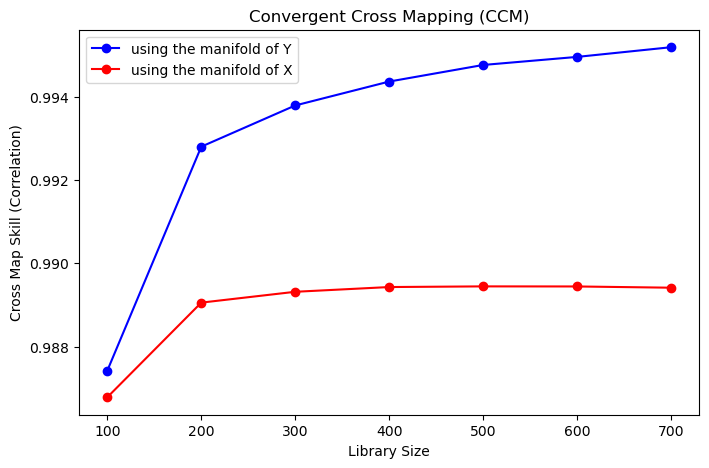

In [ ]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt

# Prepare DataFrame
df = pd.DataFrame({
    'time': time,
    'X': data_array[:, 2],  
    'Y': data_array[:, 3],    
})

# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 50,
    columns     = "X",   # predictor (ngrip)
    target      = "Y",   # target (pre)
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 200,
    verbose     = True
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# Plot the results with custom legend labels
plt.figure(figsize=(8,5))
# For X:Y: predictor is ngrip, target is ant -> label: "ant^|Mngrip"
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='using the manifold of X')
# For Y:X: predictor is ant, target is ngrip -> label: "ngrip^|Mant"
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='using the manifold of Y')

plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (Correlation)')
plt.title('Convergent Cross Mapping (CCM)')
plt.legend(loc='best')
plt.show()

   LibSize       X:Y       Y:X
0    100.0  0.762989  0.406050
1    200.0  0.806075  0.442621
2    300.0  0.823652  0.463262
3    400.0  0.825989  0.486524
4    500.0  0.830856  0.494459
5    600.0  0.833871  0.501509
6    700.0  0.838048  0.507737
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


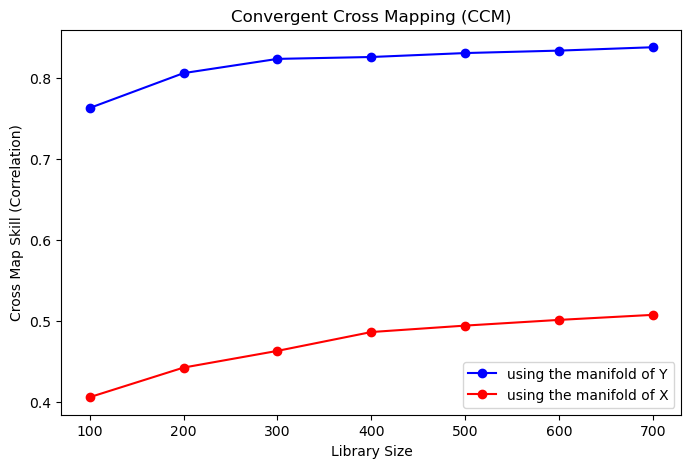

In [ ]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt

# Prepare DataFrame
df = pd.DataFrame({
    'time': time,
    'X': data_array[:, 0],  
    'Y': data_array[:, 2],    
})

# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 50,
    columns     = "X",   # predictor (ngrip)
    target      = "Y",   # target (pre)
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 200,
    verbose     = True
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# Plot the results with custom legend labels
plt.figure(figsize=(8,5))
# For X:Y: predictor is ngrip, target is ant -> label: "ant^|Mngrip"
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='using the manifold of X')
# For Y:X: predictor is ant, target is ngrip -> label: "ngrip^|Mant"
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='using the manifold of Y')

plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (Correlation)')
plt.title('Convergent Cross Mapping (CCM)')
plt.legend(loc='best')
plt.show()

   LibSize       X:Y       Y:X
0    100.0  0.997434  0.998080
1    200.0  0.998592  0.999219
2    300.0  0.998793  0.999391
3    400.0  0.998870  0.999480
4    500.0  0.998908  0.999513
5    600.0  0.998931  0.999528
6    700.0  0.998951  0.999538
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


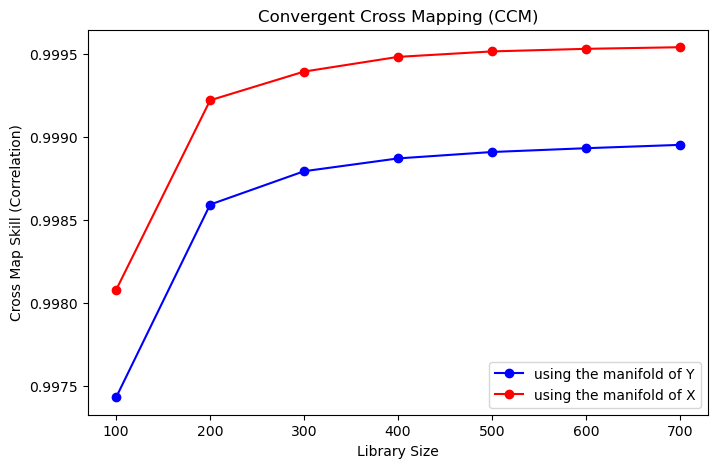

In [ ]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt

# Prepare DataFrame
df = pd.DataFrame({
    'time': time,
    'X': data_array[:, 1],  
    'Y': data_array[:, 3],    
})

# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 3,
    tau         = 50,
    columns     = "X",   # predictor (ngrip)
    target      = "Y",   # target (pre)
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 200,
    verbose     = True
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# Plot the results with custom legend labels
plt.figure(figsize=(8,5))
# For X:Y: predictor is ngrip, target is ant -> label: "ant^|Mngrip"
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='using the manifold of X')
# For Y:X: predictor is ant, target is ngrip -> label: "ngrip^|Mant"
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='using the manifold of Y')

plt.xlabel('Library Size')
plt.ylabel('Cross Map Skill (Correlation)')
plt.title('Convergent Cross Mapping (CCM)')
plt.legend(loc='best')
plt.show()